# Spatial-restricted permutation test
- Spatial structure of in-connection density.
- Spatial-restricted permutation test.

In [1]:
import numpy as np
import pandas as pd

import datajoint as dj

import matplotlib.pyplot as plt

from lib.utils import *
from lib.datajoint import *
from lib.plot import *

%matplotlib inline

## Connect to DataJoint database
- You need to be registered to access the database. Please register [here](https://forms.gle/6SeDGRT8zoLqpbfU9).
- For more information, refer to [README](https://github.com/seung-lab/MicronsBinder/blob/master/notebooks/multiscale/function/README.md) in the repository.
#### Currently, it is temporarily available without registration try running below cell.

In [2]:
# dj.config["database.host"] = "datajoint.ninai.org"
dj.config.load("dj_conf.json")
dj.conn()

pinky = dj.create_virtual_module("seung_pinky", "seung_pinky")

Connecting seung_guest@datajoint.ninai.org:3306


## All pyramidal cells (PyCs)

In [7]:
key = {"segmentation": 185}
pyc_list = (pinky.Neuron() & key).fetch("segment_id")
n_pyc = pyc_list.shape[0]

## PyC with functional data

In [12]:
cell_info_func = pd.read_csv("data/cell_functional_info.csv")

pyc_func_list = np.array(cell_info_func["segment_id"])
scan_list = np.array(cell_info_func["scan"])
n_func = pyc_func_list.shape[0]

osi_p = np.array(cell_info_func["osi_p"])
dsi_p = np.array(cell_info_func["dsi_p"])

tune_os_idx = osi_p<0.05
tune_ds_idx = dsi_p<0.05
tune_all_idx = tune_os_idx + tune_ds_idx

seg_id_os = pyc_func_list[tune_os_idx]
seg_id_ds = pyc_func_list[tune_ds_idx]
seg_id_tuned = pyc_func_list[tune_all_idx]

cell_info_func

,segment_id,scan,osi,osi_p,dsi,dsi_p
0,648518346349539895,2,1.399790,0.0085,0.360205,0.9077
1,648518346349537860,2,1.791797,0.0000,0.379977,0.7241
2,648518346349538440,2,1.369347,0.0025,0.257158,0.9983
3,648518346349538527,2,1.021334,0.0276,0.972555,0.9746
4,648518346349538209,2,1.863632,0.0000,0.100173,0.9763
...,...,...,...,...,...,...
107,648518346349537741,6,1.266736,0.0568,0.528219,0.9732
108,648518346349537901,6,1.163586,0.1148,1.162096,0.1404
109,648518346349538001,6,1.321359,0.0631,1.324058,0.0638
110,648518346349538251,6,1.436740,0.0139,1.399342,0.0287


## Get soma center coordinates

In [10]:
pyc_soma_loc = np.zeros((n_pyc, 3))
for i in range(n_pyc):
    
    seg_id = pyc_list[i]
    pyc_soma_loc[i,:] = get_soma_loc(pinky, seg_id)

In [13]:
pyc_func_soma_loc = np.zeros((n_func, 3))
for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    idx = np.where(pyc_list==seg_id)[0][0]
    pyc_func_soma_loc[i,:] = pyc_soma_loc[idx,:]

## Spatial distribution of in-connection density

In [20]:
inconn_density = np.zeros((n_func,))
for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    inconn_density[i] = (pinky.SynDensity() & {"segment_id": seg_id}).fetch1("conn_in_dens")

In [17]:
xloc = pyc_func_soma_loc[tune_all_idx,0]
yloc = pyc_func_soma_loc[tune_all_idx,1]
zloc = pyc_func_soma_loc[tune_all_idx,2]

/Users/jabae/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jabae/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jabae/.virtualenvs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


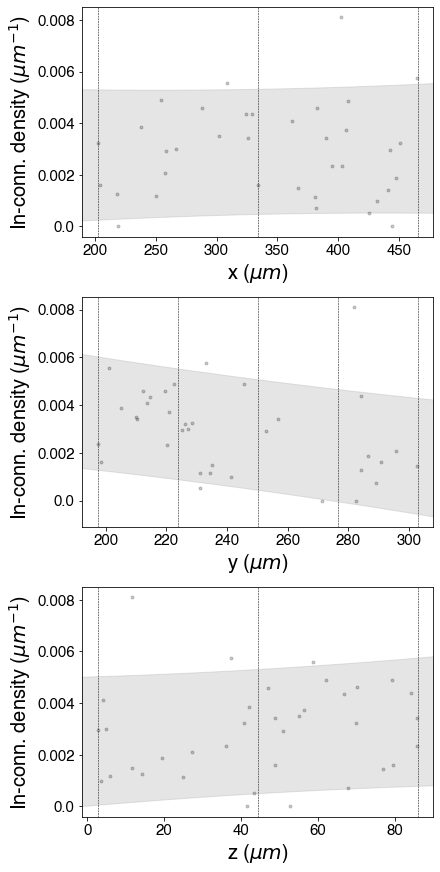

In [21]:
fig = plt.figure(figsize=(6,12), constrained_layout=True)
gs = fig.add_gridspec(3,1)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])
plot_spatial_ax(ax1, xloc, inconn_density[tune_all_idx], nbins=3, xlab="x ($\mu m$)")
plot_spatial_ax(ax2, yloc, inconn_density[tune_all_idx], nbins=5, xlab="y ($\mu m$)")
plot_spatial_ax(ax3, zloc, inconn_density[tune_all_idx], nbins=3, xlab="z ($\mu m$)")

In [22]:
xloc = pyc_func_soma_loc[tune_all_idx,0]
yloc = pyc_func_soma_loc[tune_all_idx,1]
zloc = pyc_func_soma_loc[tune_all_idx,2]

xbins = np.linspace(np.min(xloc), np.max(xloc)*1.001, 3); nx = xbins.shape[0]-1
ybins = np.linspace(np.min(yloc), np.max(yloc)*1.001, 5); ny = ybins.shape[0]-1
zbins = np.linspace(np.min(zloc), np.max(zloc)*1.001, 3); nz = zbins.shape[0]-1

val_density = inconn_density[tune_all_idx]
indices = np.arange(val_density.shape[0])

idx_list = []
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            
            valid = (xloc>=xbins[i])*(xloc<xbins[i+1]) \
                    *(yloc>=ybins[j])*(yloc<ybins[j+1]) \
                    *(zloc>=zbins[k])*(zloc<zbins[k+1])
            
            idx_list.append(indices[valid])